# Knowledge Distillation
- The concept of **knowledge distillation** is to utilize class probabilities of a higher-capacity model (teacher) as soft targets of a smaller model (student)
- The implement processes can be divided into several stages:
  1. Finish the `ResNet()` classes
  2. Train the teacher model (ResNet34) from scratch
  3. Train the student model (ResNet18) from scratch, i.e. **without KD**
  4. Define the `Distiller()` class and `loss_re()`, `loss_fe()` functions
  5. Train the student model **with KD** from the teacher model in two different ways, response-based and feature based distillation
  6. Comparison of student models w/ & w/o KD
- Requirements
  1. Response-based distillation (35%)
    - accuracy≥0.8 got 30%, the more improvement the higher score compare with student from scratch
  2. Feature-based distillation (35%)
    - same as above
  3. Report (30%)
    - Comparison of student models w/ & w/o KD
    - How you choose the **Temperature** and **alpha** in response-based KD
    - How you extracte features from the choosing intermediate layers
    - How you design the loss of your response-based and feature-based KD
    - Any problems you met & how you solved them

# Setup

In [ ]:
!pip install torchinfo
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from tqdm import tqdm
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# Download dataset

In [ ]:
validation_split = 0.2
batch_size = 128

# data augmentation and normalization
transform_train = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# download dataset
train_and_val_dataset = torchvision.datasets.CIFAR10(
    root='dataset/',
    train=True,
    transform=transform_train,
    download=True
)

test_dataset = torchvision.datasets.CIFAR10(
    root='dataset/',
    train=False,
    transform=transform_test,
    download=True
)

# split train and validation dataset
train_size = int((1 - validation_split) * len(train_and_val_dataset))
val_size = len(train_and_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_and_val_dataset, [train_size, val_size])

# create dataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_num = len(test_dataset)
test_steps = len(test_loader)

# Create teacher and student models


## Create Resnet structure

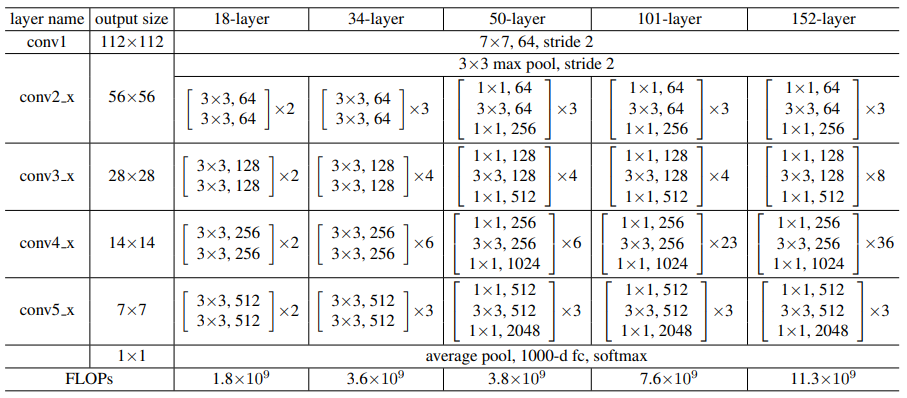

- Please finish the rest part of ResNet structure

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channel = 64

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        ######################################################################################################
        # 1. Finish the forward pass and return the output layer as well as hidden features.  #
        # 2. The output layer and hidden features will be used later for distilling.       #
        # 3. You can refer to the ResNet structure illustration to finish it.           #
        ####################################################################################################

        # x = self.conv1(x)
        # ...

        return x, [feature1, feature2, feature3, feature4]

def resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

## Teacher model

In [ ]:
Teacher = resnet34(num_classes=10)  # commment out this line if loading trained teacher model
# Teacher = torch.load('Teacher.pt')  # loading trained teacher model
Teacher = Teacher.to(device)

In [ ]:
summary(Teacher)

## Student model

In [ ]:
Student = resnet18(num_classes=10)  # commment out this line if loading trained student model
# Student = torch.load('Student.pt')  # loading trained student model
Student = Student.to(device)

In [ ]:
summary(Student)

# Define training and testing function

In [ ]:
def train_from_scratch(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    loss = []
    train_error=[]
    val_error = []
    valdation_error = []
    train_loss = []
    valdation_loss = []
    train_accuraacy = []
    valdation_accuracy= []

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        correct = 0.
        total = 0.
        V_correct = 0.
        V_total = 0.

        model.train()
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits, hidden = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            pred = logits.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(labels.data.view_as(pred))).cpu().numpy())
            total += images.size(0)
            train_acc =  correct/total
            train_bar.desc = "train epoch[{}/{}]".format(epoch + 1, epochs)

        model.eval()
        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs, hidden_outputs = model(val_images)
                loss = criterion(outputs, val_labels)
                valid_loss += loss.item() * val_images.size(0)
                pred = outputs.data.max(1, keepdim=True)[1]
                V_correct += np.sum(np.squeeze(pred.eq(val_labels.data.view_as(pred))).cpu().numpy())
                V_total += val_images.size(0)
                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)

        train_loss = train_loss / len(train_loader.dataset)
        train_error.append(train_loss)
        valid_loss = valid_loss / len(val_loader.dataset)
        val_error.append(valid_loss)
        train_accuraacy.append( correct / total)
        valdation_accuracy.append(V_correct / V_total)

        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        print('\tTrain Accuracy: %.3fd%% (%2d/%2d)\tValdation Accuracy: %.3fd%% (%2d/%2d) '% (100. * correct / total, correct, total, 100. * V_correct / V_total, V_correct, V_total))

    # torch.save(model, f'{model.__class__.__name__}.pt')
    print('Finished Training')

In [ ]:
def test(model, test_loader ,device, type=None):
    criterion = nn.CrossEntropyLoss()
    acc = 0.0
    test_loss = 0.0

    if type == None:
        model.eval()
    elif type == 'distiller':
        model.eval()
        model.teacher.eval()
        model.student.eval()
    else:
       raise ValueError(f'Error: only support response-based and feature-based distillation')

    with torch.no_grad():
        test_bar = tqdm(test_loader, file=sys.stdout)
        for test_data in test_bar:
            test_images, test_labels = test_data
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            if type == None:
                outputs, features = model(test_images)
                loss = criterion(outputs, test_labels)
            elif type == 'distiller':
                outputs, loss = model(test_images, test_labels)
            else:
                raise ValueError(f'Error: only support response-based and feature-based distillation')

            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, test_labels.to(device)).sum().item()
            test_loss += loss.item()
            test_bar.desc = "test"

    test_accurate = acc / test_num
    print('test_loss: %.3f  test_accuracy: %.3f' %(test_loss / test_steps, test_accurate * 100))
    return test_loss / test_steps, test_accurate * 100.

# The influence of temperuture

In [ ]:
logits = np.array([-5, 2, 7, 9])

In [ ]:
T = 1
softmax_1 = np.exp(logits/T) / sum(np.exp(logits/T))
plt.plot(softmax_1, label='T=1')

T = 2
softmax_2 = np.exp(logits/T) / sum(np.exp(logits/T))
plt.plot(softmax_2, label='T=2')

T = 5
softmax_5 = np.exp(logits/T) / sum(np.exp(logits/T))
plt.plot(softmax_5, label='T=5')

T = 10
softmax_10 = np.exp(logits/T) / sum(np.exp(logits/T))
plt.plot(softmax_10, label='T=10')

T = 100
softmax_100 = np.exp(logits/T) / sum(np.exp(logits/T))
plt.plot(softmax_100, label='T=100')

plt.xticks(np.arange(4), ['Cat', 'Dog', 'Bird', 'Rabbit'])
plt.legend()
plt.show

# Define distillation fuction

In [ ]:
#####################################################################
# Finish the loss function for response-based distillation. #
#####################################################################
def loss_re():
    T =
    alpha =

    return loss

In [ ]:
####################################################################
# Finish the loss function for feature-based distillation. #
####################################################################
def loss_fe():

    return loss

In [ ]:
class Distiller(nn.Module):
    def __init__(self, teacher, student, type):
        super(Distiller, self).__init__()

        ########################################
        # 1. Finish the __init__ method. #
        ########################################

        self.type = type

    def forward(self, x, target):

        #####################################
        # 2. Finish the forward pass. #
        #####################################

        if self.type == 'response':
            pass
        elif self.type == 'feature':
            pass
        else:
            raise ValueError(f'Error: only support response-based and feature-based distillation')

        return student_logits, loss_distill

In [ ]:
def train_distillation(distiller, student, train_loader, val_loader, epochs, learning_rate, device):
    ce_loss = nn.CrossEntropyLoss()
    ###########################
    # define the optimizer #
    ###########################
    optimizer = torch.optim.Adam( , lr=learning_rate)

    loss = []
    train_error=[]
    val_error = []
    valdation_error = []
    train_loss = []
    valdation_loss = []
    train_accuraacy = []
    valdation_accuracy= []

    for epoch in range(epochs):
        distiller.train()
        distiller.teacher.train()
        distiller.student.train()

        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc  = 0.0
        correct = 0.
        total = 0.
        V_correct = 0.
        V_total = 0.
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs, loss = distiller(images, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pred = outputs.data.max(1, keepdim=True)[1]
            result = pred.eq(labels.data.view_as(pred))
            result = np.squeeze(result.cpu().numpy())
            correct += np.sum(result)
            total += images.size(0)
            train_bar.desc = "train epoch[{}/{}]".format(epoch + 1, epochs)

        distiller.eval()
        distiller.teacher.eval()
        distiller.student.eval()

        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:

                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs, loss = distiller(val_images, val_labels)

                valid_loss += loss.item() * val_images.size(0)
                pred = outputs.max(1, keepdim=True)[1]
                V_correct += np.sum(np.squeeze(pred.eq(val_labels.data.view_as(pred))).cpu().numpy())
                V_total += val_images.size(0)
                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)

        train_loss = train_loss / len(train_loader.dataset)
        train_error.append(train_loss)
        valid_loss = valid_loss / len(val_loader.dataset)
        val_error.append(valid_loss)
        train_accuraacy.append( correct / total)
        valdation_accuracy.append(V_correct / V_total)

        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        print('\tTrain Accuracy: %.3fd%% (%2d/%2d)\tValdation Accuracy: %.3fd%% (%2d/%2d) '% (100. * correct / total, correct, total, 100. * V_correct / V_total, V_correct, V_total))

    print('Finished Distilling')

# Train Teacher and Student model from scratch

In [ ]:
#############################################
# Decide the epochs and learning rate #
#############################################
train_from_scratch(Teacher, train_loader, val_loader, epochs=, learning_rate=, device=device)

In [ ]:
T_loss, T_accuracy = test(Teacher, test_loader, device=device)

In [ ]:
#############################################
# Decide the epochs and learning rate #
#############################################
train_from_scratch(Student, train_loader, val_loader, epochs=, learning_rate=, device=device)

In [ ]:
S_loss, S_accuracy = test(Student, test_loader, device=device)

# Response-based distillation

In [ ]:
#############################################
# Decide the epochs and learning rate #
#############################################
Student_re = resnet18(num_classes=10)
Student_re = Student_re.to(device)
distiller_re = Distiller(Teacher, Student_re, type='response')
train_distillation(distiller_re, Student_re, train_loader, val_loader, epochs=, learning_rate=, device=device)

In [ ]:
reS_loss, reS_accuracy = test(distiller_re, test_loader, type='distiller', device=device)

# Feature-based distillation

In [ ]:
#############################################
# Decide the epochs and learning rate #
#############################################
Student_fe = resnet18(num_classes=10)
Student_fe = Student_fe.to(device)
distiller_fe = Distiller(Teacher, Student_fe, type='feature')
train_distillation(distiller_fe, Student_fe, train_loader, val_loader, epochs=, learning_rate=, device=device)

In [ ]:
ftS_loss, ftS_accuracy = test(distiller_fe, test_loader, type='distiller', device=device)

# Comparison

In [ ]:
print(f'Teacher from scratch: loss-{T_loss}, accuracy-{T_accuracy}')
print(f'Student from scratch: loss-{S_loss}, accuracy-{S_accuracy}')
print(f'Response-based student: loss-{reS_loss}, accuracy-{reS_accuracy}')
print(f'Filter-baswd student: loss-{ftS_loss}, accuracy-{ftS_accuracy}')